In [ ]:
import sqlite3
import pickle
import pandas as pd
import numpy as np
from scipy.stats import entropy
from itertools import combinations
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

In [7]:
# cursor = conn.cursor()
# cursor.execute('''CREATE TABLE IF NOT EXISTS recommendations (
#     model TEXT, user_id TEXT, business_id TEXT, real_label INTEGER,
#     UNIQUE (model, user_id, business_id)
# );''')
# conn.close()

In [ ]:

# -------------------------------
# Database & Data Loading Functions
# -------------------------------
def optimize_db(conn):
    """
    Optimize SQLite database for performance.
    """
    cursor = conn.cursor()
    cursor.executescript('''
        PRAGMA synchronous = OFF;
        PRAGMA journal_mode = MEMORY;
        PRAGMA temp_store = MEMORY;
        PRAGMA cache_size = 1000000;
    ''')
    conn.commit()


def load_recommendations(db_path, chunksize=10000):
    """
    Load recommendation data from SQLite into a DataFrame.
    """
    conn = sqlite3.connect(db_path)
    optimize_db(conn)
    df = pd.DataFrame(columns=["model", "user_id", "business_id", "real_label"])
    for chunk in pd.read_sql_query("SELECT * FROM recommendations", conn, chunksize=chunksize):
        df = pd.concat([df, chunk])
    conn.close()
    return df


def load_business_data(business_db_path, categories_encoder_path):
    """
    Load business details and category data.
    """
    conn = sqlite3.connect(business_db_path)
    categories_df = pd.read_sql_query("SELECT * FROM business_categories", conn)
    business_df = pd.read_sql_query("SELECT * FROM business_details", conn)
    conn.close()

    with open(categories_encoder_path, 'rb') as f:
        categories_encoder = pickle.load(f)
    
    categories_df['category_encoded'] = categories_encoder.transform(categories_df['category'])
    categories_df = categories_df.groupby('business_id')['category_encoded'].apply(list).reset_index()
    return business_df, categories_df


# -------------------------------
# Data Preparation Functions
# -------------------------------
def prepare_sets(df, models):
    """
    Prepare sets for pairs, items, users and per-user recommendations for each model.
    """
    pairs = {model: set(df[df['model'] == model][['user_id', 'business_id']].apply(tuple, axis=1))
             for model in models}
    items = {model: set(df[df['model'] == model]['business_id'])
             for model in models}
    users = {model: set(df[df['model'] == model]['user_id'])
             for model in models}
    recs = {model: df[df['model'] == model].groupby('user_id')['business_id'].apply(set).to_dict() 
            for model in models}
    return pairs, items, users, recs


# -------------------------------
# Analysis Functions
# -------------------------------
def compute_background_stats(df, models, items, users, recs):
    """
    Compute background statistics for each model and overall.
    """
    total_unique_items = len(set.union(*[items[model] for model in models]))
    total_unique_users = len(set.union(*[users[model] for model in models]))
    total_unique_pairs = len(set.union(*[set(df[df['model'] == model][['user_id', 'business_id']].apply(tuple, axis=1)) for model in models]))
    
    background = pd.DataFrame(columns=["Unique Users", "%", "Avg Businesses/User", "Unique Businesses", "% ", "Entropy"])
    
    for model in models:
        unique_users_model = len(users[model])
        unique_items_model = len(items[model])
        num_pairs_model = len(set(df[df['model'] == model][['user_id', 'business_id']].apply(tuple, axis=1)))
        percentage_users = (unique_users_model / total_unique_users) * 100 if total_unique_users > 0 else 0
        percentage_items = (unique_items_model / total_unique_items) * 100 if total_unique_items > 0 else 0
        
        avg_businesses_per_user = np.mean([len(recs[model][user]) for user in recs[model]]) if recs[model] else 0
        item_counts = df[df['model'] == model]['business_id'].value_counts()
        total_recs_model = len(df[df['model'] == model])
        p_i_model = item_counts / total_recs_model
        entropy_data = entropy(p_i_model)
    
        background.loc[model] = {
            "Unique Users": f"{unique_users_model}",
            "%": f"{percentage_users:.2f}%",
            "Avg Businesses/User": f"{avg_businesses_per_user:.2f}",
            "Unique Businesses": f"{unique_items_model}",
            "% ": f"{percentage_items:.2f}%",
            "Entropy": f"{entropy_data:.2f}"
        }
    
    # Combined statistics
    avg_businesses_per_user_all = np.mean([len(recs[model][user]) for model in models for user in recs[model]]) if recs else 0
    combined_item_counts = {}
    all_users = set(df['user_id'])
    for user in all_users:
        user_candidate_pool = set()
        for model in models:
            if user in recs[model]:
                user_candidate_pool.update(recs[model][user])
        for item in user_candidate_pool:
            combined_item_counts[item] = combined_item_counts.get(item, 0) + 1
    total_pairs = sum(combined_item_counts.values())
    p_i_combined = [count / total_pairs for count in combined_item_counts.values()] if total_pairs > 0 else []
    entropy_combined = entropy(p_i_combined) if p_i_combined else 0
    
    background.loc['Total'] = {
        "Unique Users": f"{total_unique_users}",
        "%": " ",
        "Avg Businesses/User": f"{avg_businesses_per_user_all:.2f}",
        "Unique Businesses": f"{total_unique_items}",
        "% ": " ",
        "Entropy": f"{entropy_combined:.2f}"
    }
    
    return background, total_unique_items, total_unique_users, total_unique_pairs


def compute_overlap_stats(pairs, items, models, total_unique_pairs, total_unique_items):
    """
    Compute overlap statistics for (user, item) pairs and items.
    """
    # Overlap for (user, item) pairs
    pair_overlap_data = []
    for model1, model2 in combinations(models, 2):
        overlap = len(pairs[model1].intersection(pairs[model2]))
        percentage_overlap = (overlap / total_unique_pairs) * 100 if total_unique_pairs > 0 else 0
        pair_overlap_data.append([f"{model1} & {model2}", overlap, f"{percentage_overlap:.2f}%"])
    
    # All models intersection for pairs
    intersection_all_pairs = set.intersection(*[pairs[model] for model in models])
    num_intersection_all_pairs = len(intersection_all_pairs)
    percentage_intersection_all_pairs = (num_intersection_all_pairs / total_unique_pairs) * 100 if total_unique_pairs > 0 else 0
    pair_overlap_data.append(["All Models", num_intersection_all_pairs, f"{percentage_intersection_all_pairs:.2f}%"])
    pair_overlap_df = pd.DataFrame(pair_overlap_data, columns=["Models", "Overlap Count", "Overlap Percentage"]).set_index("Models")
    pair_overlap_df.index.name = None

    # Overlap for items
    item_overlap_data = []
    for model1, model2 in combinations(models, 2):
        overlap = len(items[model1].intersection(items[model2]))
        percentage_overlap = (overlap / total_unique_items) * 100 if total_unique_items > 0 else 0
        item_overlap_data.append([f"{model1} & {model2}", overlap, f"{percentage_overlap:.2f}%"])
    
    # All models intersection for items
    intersection_all_items = set.intersection(*[items[model] for model in models])
    num_intersection_all_items = len(intersection_all_items)
    percentage_intersection_all_items = (num_intersection_all_items / total_unique_items) * 100 if total_unique_items > 0 else 0
    item_overlap_data.append(["All Models", num_intersection_all_items, f"{percentage_intersection_all_items:.2f}%"])
    item_overlap_df = pd.DataFrame(item_overlap_data, columns=["Models", "Item Overlap Count", "Item Overlap Percentage"]).set_index("Models")
    item_overlap_df.index.name = None

    return pair_overlap_df, item_overlap_df


def compute_venn_labels(items, models):
    """
    Compute the region counts for a Venn diagram.
    """
    only_ItemCF = len(items['ItemCF'] - items['DSSM'] - items['UserCF'])
    only_DSSM = len(items['DSSM'] - items['ItemCF'] - items['UserCF'])
    only_UserCF = len(items['UserCF'] - items['ItemCF'] - items['DSSM'])
    ItemCF_and_DSSM_not_UserCF = len((items['ItemCF'] & items['DSSM']) - items['UserCF'])
    ItemCF_and_UserCF_not_DSSM = len((items['ItemCF'] & items['UserCF']) - items['DSSM'])
    DSSM_and_UserCF_not_ItemCF = len((items['DSSM'] & items['UserCF']) - items['ItemCF'])
    all_three = len(items['ItemCF'] & items['DSSM'] & items['UserCF'])
    
    venn_labels = {
        '100': only_ItemCF,
        '010': only_DSSM,
        '001': only_UserCF,
        '110': ItemCF_and_DSSM_not_UserCF,
        '101': ItemCF_and_UserCF_not_DSSM,
        '011': DSSM_and_UserCF_not_ItemCF,
        '111': all_three
    }
    return venn_labels


def plot_venn(venn_labels):
    """
    Plot a Venn diagram using the given labels.
    """
    plt.figure(figsize=(8, 8))
    venn3(subsets=venn_labels, set_labels=('ItemCF', 'DSSM', 'UserCF'))
    plt.title("Venn Diagram of Item Overlap Across Models")
    plt.show()


def compute_jaccard_similarity(set1, set2):
    """
    Compute Jaccard similarity between two sets.
    """
    union_size = len(set1.union(set2))
    return 0 if union_size == 0 else len(set1.intersection(set2)) / union_size


def compute_overall_jaccard(items, models):
    """
    Compute overall Jaccard similarity scores between each pair of models.
    """
    similarity_scores = {}
    for model1, model2 in combinations(models, 2):
        sim = compute_jaccard_similarity(items[model1], items[model2])
        similarity_scores[f"{model1} & {model2}"] = sim
    return similarity_scores



Background Information for Unique:


,Unique Users,%,Avg Businesses/User,Unique Businesses,%,Entropy
ItemCF,848,65.13%,201.77,29083,59.75%,9.40
DSSM,1000,76.80%,5000.00,36967,75.95%,9.41
UserCF,0,0.00%,0.00,0,0.00%,0.00
Total,1302,,2798.21,48676,,9.50


Overlap of (user, item) Pairs:


,Overlap Count,Overlap Percentage
ItemCF & DSSM,18713,0.36%
ItemCF & UserCF,0,0.00%
DSSM & UserCF,0,0.00%
All Models,0,0.00%



Item Overlap:


,Item Overlap Count,Item Overlap Percentage
ItemCF & DSSM,17374,35.69%
ItemCF & UserCF,0,0.00%
DSSM & UserCF,0,0.00%
All Models,0,0.00%


c:\Users\yueny\.virtualenvs\content-recommendation-0SgTkEMC\Lib\site-packages\matplotlib_venn\layout\venn3\pairwise.py:111: UserWarning: Circle C has zero area.
  warnings.warn("Circle C has zero area.")


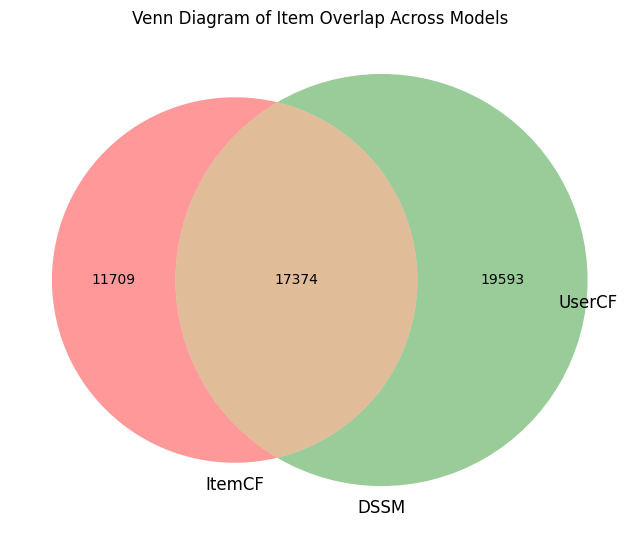

Jaccard similarity for ItemCF & DSSM: 0.36
Jaccard similarity for ItemCF & UserCF: 0.00
Jaccard similarity for DSSM & UserCF: 0.00


In [31]:

# -------------------------------
# Main Execution
# -------------------------------

# Define database paths and models
rec_db_path = './Retrieval.db'
business_db_path = '../../data/processed_data/yelp_data/yelp_business_data.db'
categories_encoder_path = 'categories_encoder.pkl'
models = [
            'ItemCF', 
            'DSSM', 
            'UserCF'
          ]

# Load data
df = load_recommendations(rec_db_path)
business_df, categories_df = load_business_data(business_db_path, categories_encoder_path)

# Prepare sets and recommendations dictionary
pairs, items, users, recs = prepare_sets(df, models)

# Compute background statistics
background, total_unique_items, total_unique_users, total_unique_pairs = compute_background_stats(df, models, items, users, recs)
print("\nBackground Information for Unique:")
display(background)

# Compute overlap statistics
pair_overlap_df, item_overlap_df = compute_overlap_stats(pairs, items, models, total_unique_pairs, total_unique_items)
print("Overlap of (user, item) Pairs:")
display(pair_overlap_df)
print("\nItem Overlap:")
display(item_overlap_df)

# Plot Venn Diagram
venn_labels = compute_venn_labels(items, models)
plot_venn(venn_labels)

# Compute and display overall Jaccard similarity scores
overall_similarity = compute_overall_jaccard(items, models)
for pair, score in overall_similarity.items():
    print(f"Jaccard similarity for {pair}: {score:.2f}")

